<h1>scDRS trait-cell type association heatmaps</h1>
This notebook contaitns code for plotting disease cell-type association z-scores produced by the scDRS `downstream_group_analyis`function. This incldues the Monte Carlo z-scores and the number of signifcant cells(FDR < 0.1)

In [1]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, ticker
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter

In [2]:
result_dir = Path("../Results")

### Functions

In [3]:
def generate_heatmap_data(merged_stats, modal_cols, label_format_map, trait_title_map,):
    all_traits = []
    all_z_scores = []
    all_pvals = []
    all_fdr01 = []
    celltypes = None

    for modal in modal_cols:
        modal_z_scores = []
        modal_pvals = []
        modal_traits = []
        modal_fdr01 = []

        for trait, cell_group_dict in merged_stats.items():
            if celltypes is None:
                major_df = cell_group_dict["major"]
                minor_df = cell_group_dict["minor"]

                major_labels = [
                    f"{label_format_map.get(celltype, celltype)} ({int(n):,})"
                    for celltype, n in zip(major_df["group"], major_df["n_cell"])
                ]
                minor_labels = [
                    f"{label_format_map.get(celltype, celltype)} ({int(n):,})"
                    for celltype, n in zip(minor_df["group"], minor_df["n_cell"])
                ]
                celltypes = major_labels + minor_labels

            modal_traits.append(trait_title_map.get(trait, trait))

            z = list(cell_group_dict["major"][modal + "_MCZ"]) + list(cell_group_dict["minor"][modal + "_MCZ"])
            p = list(cell_group_dict["major"][modal + "_MCP"]) + list(cell_group_dict["minor"][modal + "_MCP"])

            fdr_01 = list(cell_group_dict["major"][modal + "_FDR_0.1_frac"]) + list(cell_group_dict["minor"][modal + "_FDR_0.1_frac"])
            modal_fdr01.append(fdr_01)
            
            modal_z_scores.append(z)
            modal_pvals.append(p)

        all_traits.extend(modal_traits)
        all_fdr01.append(np.array(modal_fdr01))
        all_z_scores.append(np.array(modal_z_scores))
        all_pvals.append(np.array(modal_pvals))

    return np.vstack(all_fdr01), np.vstack(all_z_scores), np.vstack(all_pvals), celltypes, all_traits



def reorder_heatmap(z_matrix, p_matrix, fdr01_matrix, celltypes, all_traits, cell_order=None, trait_order=None):
    
    if cell_order:
        def extract_base_label(label):
            return re.sub(r"\s*\(.*\)$", "", label)

        base_labels = [extract_base_label(label) for label in celltypes]
        label_map = {label: i for i, label in enumerate(cell_order)}
        col_order = sorted(range(len(celltypes)), key=lambda i: label_map.get(base_labels[i], float('inf')))

        celltypes = [celltypes[i] for i in col_order]
        z_matrix = z_matrix[:, col_order]
        p_matrix = p_matrix[:, col_order]
        fdr01_matrix = fdr01_matrix[:, col_order]

    if trait_order:
        trait_map = {trait: i for i, trait in enumerate(trait_order)}
        row_order = sorted(range(len(all_traits)), key=lambda i: trait_map.get(all_traits[i], float('inf')))

        all_traits = [all_traits[i] for i in row_order]
        z_matrix = z_matrix[row_order, :]
        p_matrix = p_matrix[row_order, :]
        fdr01_matrix = fdr01_matrix[row_order, :]

    return z_matrix, p_matrix, fdr01_matrix, celltypes, all_traits


def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(range(data.shape[1]), labels=col_labels,
                  rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(data.shape[0]), labels=row_labels)

    # Move horizontal axes labeling to bottom
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    return im, cbar
    

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def merge_trait_stats(stats_dict):
    """
    Merges modality-specific stats across 'major' and 'minor' group types
    for each trait in stats_dict. Adds 'n_cell' only once at the end.

    Parameters:
        stats_dict (dict): Nested dictionary of the form:
            stats_dict[trait][modality]['major' or 'minor'] -> DataFrame

    Returns:
        dict: A merged version of stats_dict, with structure:
            merged_stats[trait]['major' or 'minor'] -> merged DataFrame
    """
    merged_stats = {}

    for trait, modality_data in stats_dict.items():
        merged_stats[trait] = {}

        for group_type in ["major", "minor"]:
            dfs = []
            n_cell_df = None  # to store once

            for modality, group_data in modality_data.items():
                df = group_data[group_type].copy()

                # Add FDR-based fraction column
                fdr_frac_col = f'{modality}_FDR_0.1_frac'
                df[fdr_frac_col] = df['n_fdr_0.1'] / df['n_cell']

                # Capture n_cell once
                if n_cell_df is None:
                    n_cell_df = df[['group', 'n_cell']].copy()

                # Subset and rename
                sub_df = df[['group', 'assoc_mcz', 'assoc_mcp', fdr_frac_col]].copy()
                sub_df.rename(columns={
                    'assoc_mcz': f'{modality}_MCZ',
                    'assoc_mcp': f'{modality}_MCP'
                }, inplace=True)

                dfs.append(sub_df)

            # Merge modality-specific data
            merged_df = dfs[0]
            for other_df in dfs[1:]:
                merged_df = pd.merge(merged_df, other_df, on='group')

            # Add n_cell back at the end
            merged_df = pd.merge(merged_df, n_cell_df, on='group')

            merged_stats[trait][group_type] = merged_df

    return merged_stats

<h1>1. Modality Results

### Load data

In [4]:
stats_dict = {}
modalities = ["ATAC+RNA", "ATAC", "RNA"]
modal_res_dir = result_dir / "multiomics"
for trait_dir in modal_res_dir.iterdir():
    trait = trait_dir.stem
    stats_dict[trait] = {}
    
    for stats_dir in trait_dir.iterdir():
        if stats_dir.stem == "stats":
            for group_stats in stats_dir.iterdir():
                if group_stats.stem == "group_stats":
                    for stats_file in group_stats.iterdir():
                        for modal in modalities:
                            
                            if stats_file.stem.startswith(f"{modal}_"):
                        
                                if modal not in stats_dict[trait]:
                                    stats_dict[trait][modal] = {}
            
                                if "lowerres" in stats_file.stem:
                                    stats_dict[trait][modal]["major"] = pd.read_csv(stats_file)
    
                                else:
                                    df = pd.read_csv(stats_file)
                                    # Remove NK as it is also present in major celltypes, scores are identical. CD8 Naive only has 1 cell
                                    df = df[~df["group"].isin(["NK", "CD8 Naive"])]

                                    stats_dict[trait][modal]["minor"] = df
                            


In [5]:
print(stats_dict["px_multiple_sclerosis_w10kb"]["ATAC+RNA"]["minor"])

             group   n_cell  n_ctrl  assoc_mcp  assoc_mcz  n_fdr_0.05  \
0        CD14 Mono  27119.0  1000.0   0.143856   1.065945       245.0   
1        CD16 Mono   3083.0  1000.0   0.000999   7.048963       204.0   
2        CD4 Naive  17162.0  1000.0   0.000999   5.127182       324.0   
3          CD4 TCM  21934.0  1000.0   0.000999   4.165387       280.0   
5        CD8 TEM_1  13285.0  1000.0   0.000999   5.920902       330.0   
6   Intermediate B    985.0  1000.0   0.000999   7.622503       105.0   
7         Memory B   6467.0  1000.0   0.000999   8.428152       641.0   
9              cDC    149.0  1000.0   0.002997   3.521228         2.0   
10             gdT     13.0  1000.0   0.415584   0.181969         0.0   
11             pDC    886.0  1000.0   0.110889   1.226808         7.0   

    n_fdr_0.1  n_fdr_0.2  
0       466.0      938.0  
1       329.0      561.0  
2       654.0     1379.0  
3       596.0     1323.0  
5       586.0     1225.0  
6       158.0      236.0  
7      

### Format stats

### Construct heatmap data

In [6]:
modal_cols = ["RNA", "ATAC", "ATAC+RNA"]

label_format_map = {
    "B": "B",
    "CD4T": "CD4⁺ T",
    "CD8T": "CD8⁺ T",
    "DC": "Dendritic",
    "NK": "Natural Killer",
    "monocyte": "Monocyte",
    "CD14 Mono": "CD14⁺ Monocyte",
    "CD16 Mono": "CD16⁺ Monocyte",
    "CD4 Naive": "CD4⁺ Naive",
    "CD4 TCM": "CD4⁺ TCM",
    "CD8 Naive": "CD8⁺ Naive",
    "CD8 TEM_1": "CD8⁺ TEM",
    "Intermediate B": "Intermediate B",
    "Memory B": "Memory B",
    "cDC": "Classical DC",
    "gdT": "γδ T",
    "pDC": "Plasmacytoid DC"
}

trait_title_map = {
    'px_arthritis_w10kb' : 'Rheumatoid Arthritis (RA)',
    'px_multiple_sclerosis_w10kb': 'Multiple Sclerosis (MS)',
    'px_height_w10kb': 'Height',
    'px_BMI_w10kb': 'Body Mass Index (BMI)',
    'px_T1D_w10kb': 'Type 1 Diabetes (T1D)',
    'px_IBD_w10kb': 'Inflammatory Bowel Disease (IBD)',
    'px_mono_count_w10kb': 'Monocyte Count (MC)',
    'px_mono_perc_leuk_w10kb': 'Monocytes % of Leukocytes (MP)',
}


cell_order = [
    "B", "Intermediate B", "Memory B",
    "CD4⁺ T", "CD4⁺ Naive", "CD4⁺ TCM",
    "CD8⁺ T", "CD8⁺ Naive", "CD8⁺ TEM",
    "Monocyte", "CD14⁺ Monocyte", "CD16⁺ Monocyte",
    "Dendritic", "Classical DC", "Plasmacytoid DC",
    "Natural Killer", "γδ T"
]

trait_order = [
    'px_multiple_sclerosis_w10kb',
    'px_arthritis_w10kb',
    'px_IBD_w10kb',
    'px_T1D_w10kb',
    'px_height_w10kb',
    'px_BMI_w10kb',
    'px_mono_count_w10kb',
    'px_mono_perc_leuk_w10kb'
]


ordered_stats = {
    trait: stats_dict[trait]
    for trait in trait_order
    if trait in stats_dict
}

merged_stats = merge_trait_stats(ordered_stats)

fdr01_matrix, z_matrix, p_matrix, celltypes, all_traits = generate_heatmap_data(
    merged_stats,
    modal_cols,
    label_format_map,
    trait_title_map,

)
z_matrix, p_matrix, fdr01_matrix, celltypes, all_traits = reorder_heatmap(
    z_matrix,
    p_matrix,
    fdr01_matrix,
    celltypes,
    all_traits,
    cell_order=cell_order
)


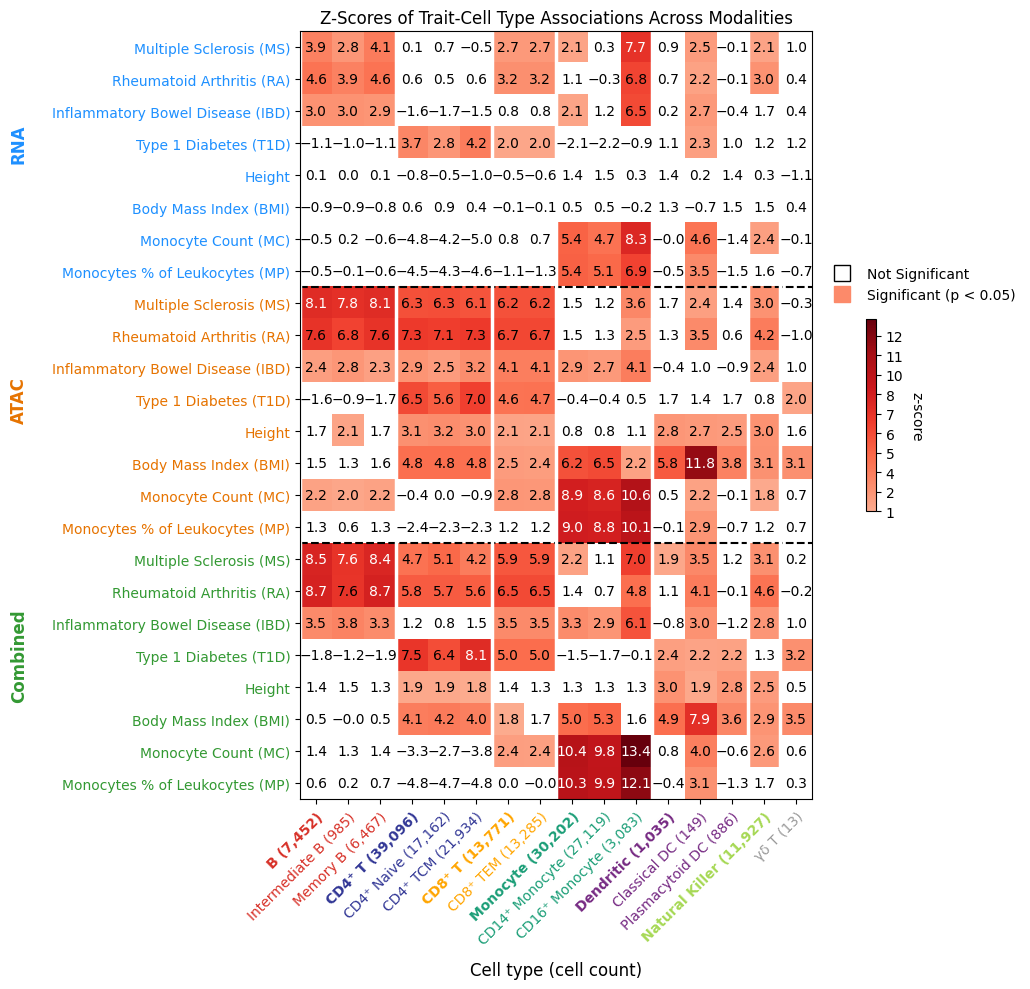

In [15]:
#######################################
# Create heatmap
#######################################

# NOTE: This threshold is correct for visual representation in this specific case (checked by also plotting pvals < 0.5). 
#       Does not reflect the actual significance threshold.
z_threshold = 1.75 

# Build custom colormap: white below threshold, Reds above
reds = plt.cm.Reds(np.linspace(0.3, 1, 256))
white = np.array([[1, 1, 1, 1]])  # white RGBA
newcolors = np.vstack((white, reds))
custom_cmap = ListedColormap(newcolors)

# Normalize: values < threshold → 0 (white), rest → spread across Reds
norm_bins = np.concatenate([[z_threshold - 1e-6], np.linspace(z_threshold, np.max(z_matrix), 256)])
norm = BoundaryNorm(norm_bins, custom_cmap.N)

fig, ax = plt.subplots(figsize=(12, 10))

im, cbar = heatmap(
    data=z_matrix,
    row_labels=all_traits,
    col_labels=celltypes,
    ax=ax,
    cmap=custom_cmap,
    norm=norm,
    cbarlabel="z-score",
    cbar_kw={"shrink":0.25}
)

# Format cbar to int ticks
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x)}"))
cbar.ax.yaxis.set_minor_locator(ticker.NullLocator())

plt.title("Z-Scores of Trait-Cell Type Associations Across Modalities")
ax.set_xlabel("Cell type (cell count)", fontsize=12, labelpad=10)

annotate_heatmap(im, valfmt="{x:.1f}")

#######################################
# Label colors / hlines - vlines
#######################################
modal_colors = ["dodgerblue", "#E67300", "#339933"]
block_size = len(all_traits) // len(modal_cols)
color_idx = -1

for i, label in enumerate(ax.get_yticklabels()):
    if i % block_size == 0:
        color_idx += 1
        if i > 0:  # don't draw a line at the top
            y = i - 0.5
            ax.hlines(y, -0.5, z_matrix.shape[1] - 0.5, color="black", linewidth=1.5, linestyle="--")
    
    if color_idx < len(modal_colors):
        label.set_color(modal_colors[color_idx])

# Add modality labels
modalities = ["RNA", "ATAC", "Combined"]
modal_pos = [6, 16, 22]
for i, modality in enumerate(modalities):
    y = (modal_pos[i-1] + modal_pos[i]) / 2 if i > 0 else modal_pos[i] / 2
    ax.text(-9, y, modality, va='center', ha='right', rotation=90, fontsize=12, fontweight='bold', color=modal_colors[i], transform=ax.transData)

# Celltypee Labels
celltype_colors = [
    "#D73027",  # Strong Red
    "#313695",  # Dark Blue (different from dodgerblue)
    "orange",  # Light Orange/Yellow
    "#1B9E77",  # Teal
    "#762A83",  # Purple
    "#A6D854",  # Light Green
    "#999999"   # grey
]

# Bold x-axis labels
major_loc = [0, 3, 6, 8, 11, 14]
ci = -1
for i, label in enumerate(ax.get_xticklabels()):
    if i == len(ax.get_xticklabels()) - 1:
        label.set_color(celltype_colors[ci + 1])
        ax.axvline(x=i - 0.5, color="white", linewidth=2.5, linestyle="-")
        break
        
    if i in major_loc:
        label.set_fontweight("bold")
        ax.axvline(x=i - 0.5, color="white", linewidth=2.5, linestyle="-")
        ci += 1
    label.set_color(celltype_colors[ci])

#######################################
# Legend
#######################################
redclr = plt.cm.Reds(0.4)
legend_elements = [
    Line2D([0], [0], marker='s', color='white', markerfacecolor='white',
           markeredgecolor='black', markersize=12, linestyle='None', label='Not Significant'),
    Line2D([0], [0], marker='s', color=redclr, markerfacecolor=redclr,
           markersize=12, linestyle='None', label='Significant (p < 0.05)')
]

# Add legend to plot
ax.legend(
    handles=legend_elements,
    loc='upper left',
    bbox_to_anchor=(1.02, 0.7),  
    borderaxespad=0,
    frameon=False,
    fontsize=10,
)


fig.tight_layout()
plt.show()

# Save plot
fig.savefig("../Results/all_trait_association_heatmap_v5.png", dpi=300, bbox_inches="tight")

- Overall signal for ATAC gene scores seems to be higher then RNA

- Can the results for namely the CD4 T cells be reliable if Height for gene scores shows significance? this is supposed to be a negative control
  Height in general (aswell as BMI, which may be linked to blood celss) has a lot of significant cell type associations.

- The combined modalities shows an increased significance for monocyte count and monocytes % of Leukocytes for monocytes.

- Arthritis are all the same myleoid celltype or something, major major celltype

- classical DC show significance for nearly every single trait across all modalities. Might be due to relatively low cell count
   - Also extremely significant for BMI for some reason, in contrast to RNA which shows maybe the "expected" significane levels.
 
- Signicicance for BMI in classical DC is extremely high for ATAC and combinec, but not for RNA. Perplexity says Type 2 DC(which are classical DC) is significantly associated with BMI, aswell as T helper cells (CD4, also significant). This might highlight an example to use.

- Another observation in arthritis is high significance in RNA, but low significance in gene scores. Perplexity says arthritis is strongly associated with CD16+ monocytes. 


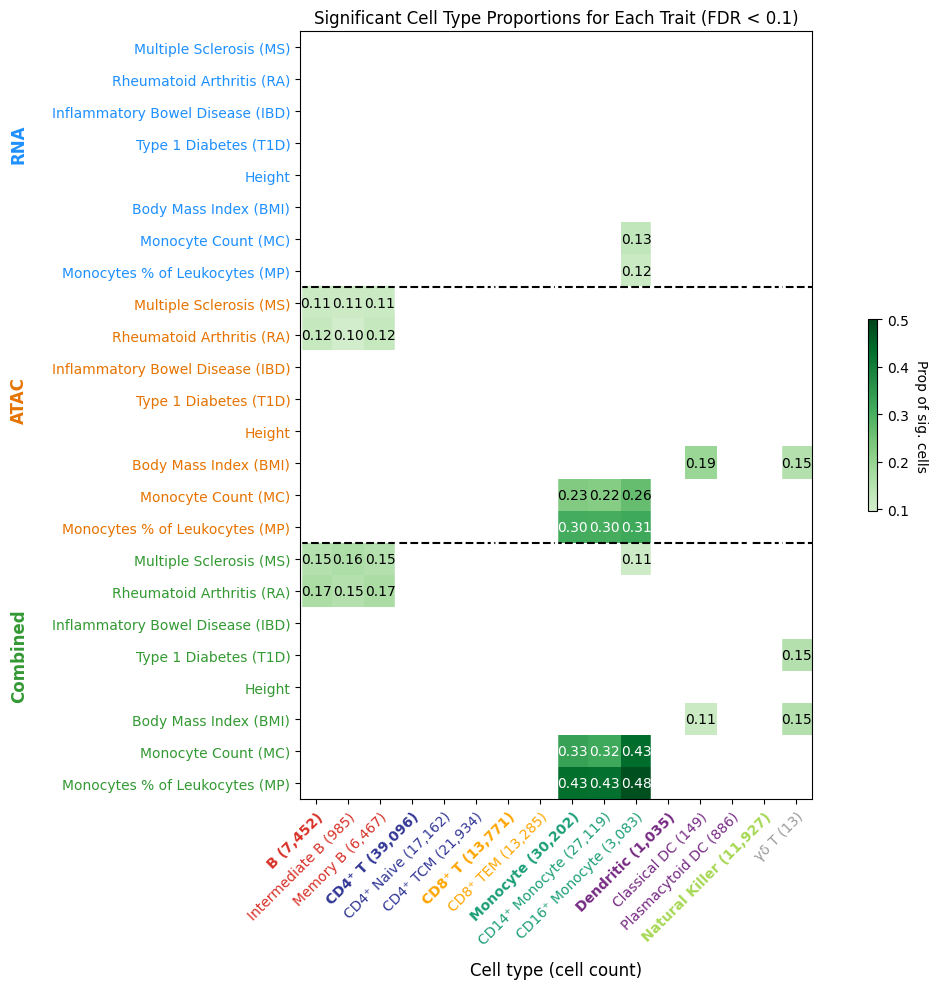

In [13]:
#######################################
# Create heatmap
#######################################
from matplotlib.colors import Normalize
greens = plt.cm.Greens(np.linspace(0.2, 1, 256))
green_cmap = ListedColormap(greens)
norm = Normalize(vmin=0.095, vmax=0.5)
green_cmap.set_under('white')  # or 'lightgray', or 'none' for transparency

fig, ax = plt.subplots(figsize=(12, 10))

im, cbar = heatmap(
    data=fdr01_matrix,
    row_labels=all_traits,
    col_labels=celltypes,
    ax=ax,
    cmap=green_cmap,
    norm=norm,
    cbarlabel="Prop of sig. cells",
    cbar_kw={"shrink":0.25}
)

plt.title("Significant Cell Type Proportions for Each Trait (FDR < 0.1)")
ax.set_xlabel("Cell type (cell count)", fontsize=12, labelpad=10)

def hide_zeros_formatter(x, _):
    rounded = round(x, 2)
    if rounded < 0.1:
        return ""  # Return empty string for 0.00
    return f"{rounded:.2f}"

annotate_heatmap(im, valfmt=FuncFormatter(hide_zeros_formatter))

#######################################
# Label colors / hlines - vlines
#######################################
modal_colors = ["dodgerblue", "#E67300", "#339933"]
block_size = len(all_traits) // len(modal_cols)
color_idx = -1

for i, label in enumerate(ax.get_yticklabels()):
    if i % block_size == 0:
        color_idx += 1
        if i > 0:  # don't draw a line at the top
            y = i - 0.5
            ax.hlines(y, -0.5, z_matrix.shape[1] - 0.5, color="black", linewidth=1.5, linestyle="--")
    
    if color_idx < len(modal_colors):
        label.set_color(modal_colors[color_idx])

# Add modality labels
modalities = ["RNA", "ATAC", "Combined"]
modal_pos = [6, 16, 22]
for i, modality in enumerate(modalities):
    y = (modal_pos[i-1] + modal_pos[i]) / 2 if i > 0 else modal_pos[i] / 2
    ax.text(-9, y, modality, va='center', ha='right', rotation=90, fontsize=12, fontweight='bold', color=modal_colors[i], transform=ax.transData)

# Celltypee Labels
celltype_colors = [
    "#D73027",  # Strong Red
    "#313695",  # Dark Blue (different from dodgerblue)
    "orange",  # Light Orange/Yellow
    "#1B9E77",  # Teal
    "#762A83",  # Purple
    "#A6D854",  # Light Green
    "#999999"   # grey
]

# Bold x-axis labels
major_loc = [0, 3, 6, 8, 11, 14]
ci = -1
for i, label in enumerate(ax.get_xticklabels()):
    if i == len(ax.get_xticklabels()) - 1:
        label.set_color(celltype_colors[ci + 1])
        ax.axvline(x=i - 0.5, color="white", linewidth=2.5, linestyle="-")
        break
        
    if i in major_loc:
        label.set_fontweight("bold")
        ax.axvline(x=i - 0.5, color="white", linewidth=2.5, linestyle="-")
        ci += 1
    label.set_color(celltype_colors[ci])

#######################################
# Legend
#######################################
# redclr = plt.cm.Reds(0.4)
# legend_elements = [
#     Line2D([0], [0], marker='s', color='white', markerfacecolor='white',
#            markeredgecolor='black', markersize=12, linestyle='None', label='Not Significant'),
#     Line2D([0], [0], marker='s', color=redclr, markerfacecolor=redclr,
#            markersize=12, linestyle='None', label='Significant (p < 0.05)')
# ]

# # Add legend to plot
# ax.legend(
#     handles=legend_elements,
#     loc='upper left',
#     bbox_to_anchor=(1.02, 0.7),  
#     borderaxespad=0,
#     frameon=False,
#     fontsize=10,
# )


fig.tight_layout()
plt.show()

fig.savefig("../Results/all_trait_sig_cells_heatmap_<0.1.png", dpi=300, bbox_inches="tight")

# EQTL Results

In [9]:
# Helper functions to read 

# stats_dict (dict): Nested dictionary of the form:
#     stats_dict[trait][modality]['major' or 'minor'] -> DataFrame

def load_stats_files(stats_dir):
    """
    Reads 'major' and 'minor' celltype stats from the stats_dir.
    Returns a dict with optional 'major' and 'minor' DataFrames.
    """
    result = {}
    for stats_file in stats_dir.iterdir():
        if "celltype_imputed_lowerres" in stats_file.stem:
            result["major"] = pd.read_csv(stats_file)
        elif "celltype_imputed" in stats_file.stem:
            df = pd.read_csv(stats_file)
            
            # Optional filtering
            df = df[~df["group"].isin(["NK", "CD8 Naive"])]
            result["minor"] = df
    return result

def build_stats_dict(result_dir):
    """
    Walks through ATAC_gene_expression_pp directory and builds
    a nested stats_dict: stats_dict[trait][modality]['major'/'minor'] -> DataFrame
    """
    stats_dict = {}
    for trait_dir in result_dir.iterdir():
        trait_stem = trait_dir.stem

        if trait_stem.endswith("eqtl"):
            trait = trait_stem.split("_eqtl")[0]
            modality = "eQTLs"
        elif trait_stem.endswith("_w10kb"):
            trait = trait_stem.split("_w10kb")[0]
            modality = "Baseline"
        else:
            continue

        for stats_dir in trait_dir.iterdir():
            if stats_dir.stem == "stats":
                stats_dict.setdefault(trait, {})[modality] = load_stats_files(stats_dir)

    return stats_dict



In [10]:
trait_title_map = {
    'px_arthritis' : 'Rheumatoid Arthritis (RA)',
    'px_multiple_sclerosis': 'Multiple Sclerosis (MS)',
    'px_height': 'Height',
    'px_BMI': 'Body Mass Index (BMI)',
    'px_T1D': 'Type 1 Diabetes (T1D)',
    'px_IBD': 'Inflammatory Bowel Disease (IBD)',
    'px_mono_count_w': 'Monocyte Count (MC)',
    'px_mono_perc_leuk': 'Monocytes % of Leukocytes (MP)',
}


trait_order = [
    'px_multiple_sclerosis',
    'px_arthritis',
    'px_IBD',
    'px_T1D',
    'px_height',
    'px_BMI',
    'px_mono_count',
    'px_mono_perc_leuk'
]

modal_cols = ["Baseline", "eQTLs"]

stats_dict = build_stats_dict(result_dir / "ATAC_gene_expression_pp")

ordered_stats = {
    trait: stats_dict[trait]
    for trait in trait_order
    if trait in stats_dict
}
        
merged_stats = merge_trait_stats(ordered_stats)

_, z_matrix, p_matrix, celltypes, all_traits = generate_heatmap_data(
    merged_stats,
    modal_cols,
    label_format_map,
    trait_title_map
)

# Reorder heatmap
_, z_matrix, p_matrix, celltypes, all_traits = reorder_heatmap(
    _, z_matrix, p_matrix, celltypes, all_traits,
    cell_order=cell_order
)

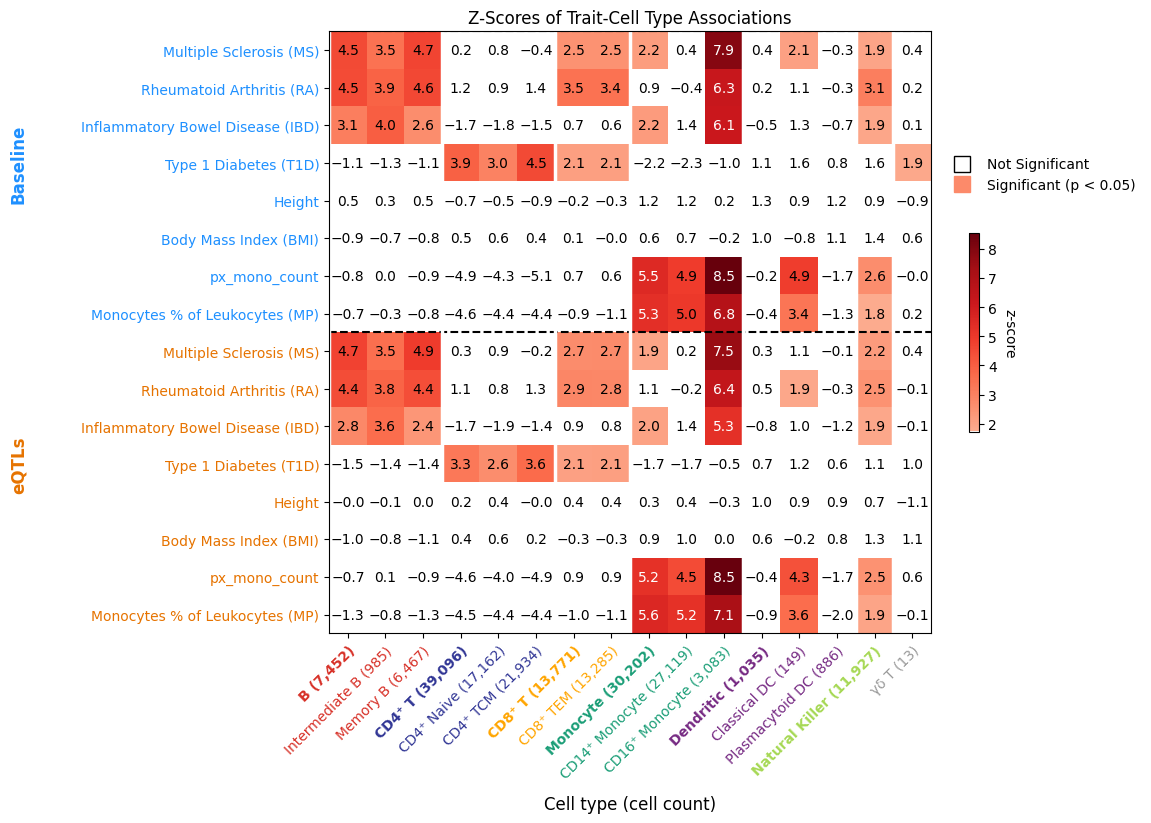

In [11]:
#######################################
# Create heatmap
#######################################

# NOTE: This threshold is correct for visual representation in this specific case (manually checked). Does not reflect the actual z_score threshold.
z_threshold = 1.75 

# Build custom colormap: white below threshold, Reds above
reds = plt.cm.Reds(np.linspace(0.3, 1, 256))
white = np.array([[1, 1, 1, 1]])  # white RGBA
newcolors = np.vstack((white, reds))
custom_cmap = ListedColormap(newcolors)

# Normalize: values < threshold → 0 (white), rest → spread across Reds
norm_bins = np.concatenate([[z_threshold - 1e-6], np.linspace(z_threshold, np.max(z_matrix), 256)])
norm = BoundaryNorm(norm_bins, custom_cmap.N)

fig, ax = plt.subplots(figsize=(12, 10))

im, cbar = heatmap(
    data=z_matrix,
    row_labels=all_traits,
    col_labels=celltypes,
    ax=ax,
    cmap=custom_cmap,
    norm=norm,
    cbarlabel="z-score",
    cbar_kw={"shrink":0.25}
)

# Format cbar to int ticks
cbar.set_ticks([2, 3, 4, 5, 6, 7, 8])
cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
cbar.ax.yaxis.set_minor_locator(ticker.NullLocator())

annotate_heatmap(im, valfmt="{x:.1f}")

plt.title("Z-Scores of Trait-Cell Type Associations")
ax.set_xlabel("Cell type (cell count)", fontsize=12, labelpad=10)

#######################################
# Label colors / hlines - vlines
#######################################
modal_colors = ["dodgerblue", "#E67300"]
color_idx = -1
block_size = len(all_traits) // len(modal_cols)
for i, label in enumerate(ax.get_yticklabels()):
    if i % block_size == 0:
        color_idx += 1
        y = i - 0.5 
        ax.hlines(y, -0.5, z_matrix.shape[1] - 0.5, color="black", linewidth=1.5, linestyle="--")
    
    if color_idx < len(modal_colors):
        label.set_color(modal_colors[color_idx])

# Add modality labels
modalities = ["Baseline", "eQTLs"]
modal_pos = [6, 16, 22]
for i, modality in enumerate(modalities):
    y = (modal_pos[i-1] + modal_pos[i]) / 2 if i > 0 else modal_pos[i] / 2
    ax.text(-8.5, y, modality, va='center', ha='right', rotation=90, fontsize=12, fontweight='bold', color=modal_colors[i], transform=ax.transData)

# Celltypee Labels
celltype_colors = [
    "#D73027",  # Strong Red
    "#313695",  # Dark Blue (different from dodgerblue)
    "orange",  # Light Orange/Yellow
    "#1B9E77",  # Teal
    "#762A83",  # Purple
    "#A6D854",  # Light Green
    "#999999"   # grey
]

# Bold x-axis labels
major_loc = [0, 3, 6, 8, 11, 14]
ci = -1
for i, label in enumerate(ax.get_xticklabels()):
    if i == len(ax.get_xticklabels()) - 1:
        label.set_color(celltype_colors[ci + 1])
        ax.axvline(x=i - 0.5, color="white", linewidth=2.5, linestyle="-")
        break
        
    if i in major_loc:
        label.set_fontweight("bold")
        ax.axvline(x=i - 0.5, color="white", linewidth=2.5, linestyle="-")
        ci += 1
    label.set_color(celltype_colors[ci])

#######################################
# Legend
#######################################
redclr = plt.cm.Reds(0.4)
legend_elements = [
    Line2D([0], [0], marker='s', color='white', markerfacecolor='white',
           markeredgecolor='black', markersize=12, linestyle='None', label='Not Significant'),
    Line2D([0], [0], marker='s', color=redclr, markerfacecolor=redclr,
           markersize=12, linestyle='None', label='Significant (p < 0.05)')
]

# Add legend to plot
ax.legend(
    handles=legend_elements,
    loc='upper left',
    bbox_to_anchor=(1.02, 0.80),  
    borderaxespad=0,
    frameon=False,
    fontsize=10,
)


fig.tight_layout()
plt.show()

In [43]:
fig.savefig("../Results/eqtls_trait_association_heatmap_v3.png", dpi=300, bbox_inches="tight")